In [19]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
import glob

In [40]:
test_df = pd.read_csv('../data/drugcell_all.txt', sep='\t', header=None, names=['C', 'D', 'AUC'])
drugs = pd.read_csv('../data/drug2ind.txt', sep='\t', header=None, names=['I', 'D'])['D']

nest_drugcell_pred = np.loadtxt('../result/drugcell_all.predict')
nest_drugcell_pred_cv = np.loadtxt('../result/drugcell_cv.predict')
nest_drugcell_pred_k2 = np.loadtxt('../result/drugcell_k2.predict')
nest_drugcell_pred_k4 = np.loadtxt('../result/drugcell_k4.predict')
nest_drugcell_pred_k10 = np.loadtxt('../result/drugcell_k10.predict')
drugcell_pred = np.loadtxt('../../drugcell/result/drugcell_all.predict')
elastic_net_pred = np.loadtxt('../result/elastic_net.predict')

In [12]:
#Separating data for each drug

def get_drug_pos_map(test_df, drugs):
    drug_pos_map = {d:[] for d in drugs}
    for i, row in test_df.iterrows():
        drug_pos_map[row['D']].append(i)
    return drug_pos_map

In [13]:
#Arrange the drugs in descending order of correlation

def sort_drugs_corr(drugs, test_df, predicted):
    drug_corr_map = {}
    drug_pos_map = get_drug_pos_map(test_df, drugs)
    for d in drugs:
        test_vals = np.take(test_df['AUC'], drug_pos_map[d])
        pred_vals = np.take(predicted, drug_pos_map[d])
        drug_corr_map[d] = stats.spearmanr(test_vals, pred_vals)[0]
    return {drug:corr for drug,corr in sorted(drug_corr_map.items(), key=lambda item:item[1], reverse=True)}


In [11]:
drug_corr_map = sort_drugs_corr(drugs, test_df, nest_drugcell_pred)

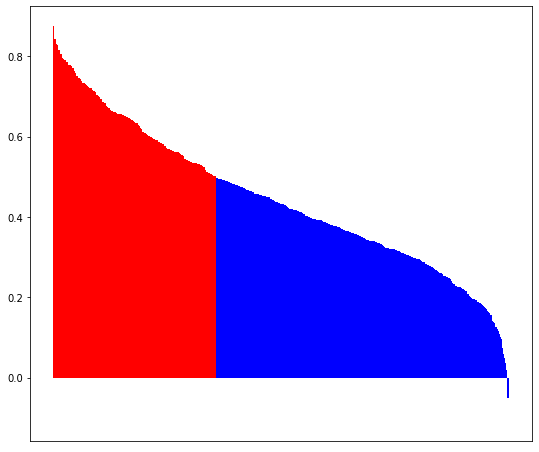

In [21]:
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111)
x_red = []
y_red = []
x_blue = []
y_blue = []
for d in drug_corr_map.keys():
    if drug_corr_map[d] > 0.5:
        x_red.append(d)
        y_red.append(drug_corr_map[d])
    else:
        x_blue.append(d)
        y_blue.append(drug_corr_map[d])
ax.bar(x_red, y_red, color='red', width=1.0)
ax.bar(x_blue, y_blue, color='blue', width=1.0)
ax.set_xticks([])
plt.show()

In [8]:
def get_boxplot(test_df, predicted, x_title, y_title):
    
    df = pd.DataFrame(list(zip(test_df['AUC'], predicted)), columns=['t', 'p'])
    df = df.sort_values(by=['t'])

    data = []
    for i in range(9):
        temp = []
        data.append(temp)

    for i, row in df.iterrows():
        if row['t'] < 0.3:
            data[0].append(row['p'])
        elif row['t'] < 0.4:
            data[1].append(row['p'])
        elif row['t'] < 0.5:
            data[2].append(row['p'])
        elif row['t'] < 0.6:
            data[3].append(row['p'])
        elif row['t'] < 0.7:
            data[4].append(row['p'])
        elif row['t'] < 0.8:
            data[5].append(row['p'])
        elif row['t'] < 0.9:
            data[6].append(row['p'])
        elif row['t'] < 1.0:
            data[7].append(row['p'])
        else:
            data[8].append(row['p'])
    
    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111)
    ax.boxplot(data, showfliers=False, labels=['0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0', 'Inf'])
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2])
    ax.grid(True)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    
    plt.show()


In [9]:
def compare_corr(x_test_df, y_test_df, x_label, y_label, x_title, y_title):
    X_corr = []
    Y_corr = []
    x_drug_pos_map = get_drug_pos_map(x_test_df, drugs)
    y_drug_pos_map = get_drug_pos_map(y_test_df, drugs)
    for d in drugs:
        x_test_vals = np.take(x_test_df['AUC'], x_drug_pos_map[d])
        y_test_vals = np.take(y_test_df['AUC'], y_drug_pos_map[d])
        X_vals = np.take(x_label, x_drug_pos_map[d])
        Y_vals = np.take(y_label, y_drug_pos_map[d])
        X_c = stats.spearmanr(X_vals, x_test_vals)[0]
        Y_c = stats.spearmanr(Y_vals, y_test_vals)[0]
        X_corr.append(X_c)
        Y_corr.append(Y_c)

    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111)
    ax.scatter(X_corr, Y_corr, s = 10)

    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    plt.show()

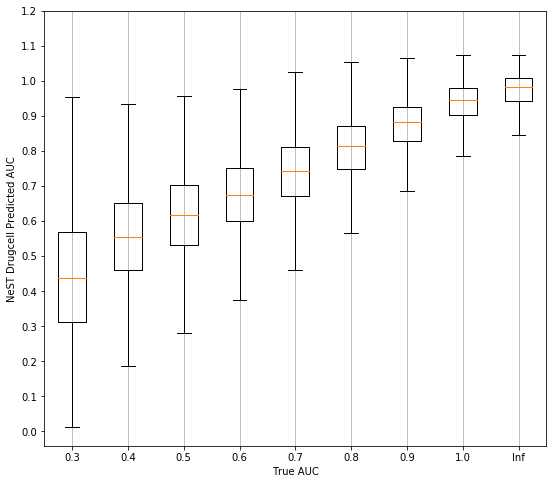

In [48]:
#NeST Drugcell

get_boxplot(test_df, nest_drugcell_pred_cv, "True AUC", "NeST Drugcell Predicted AUC")

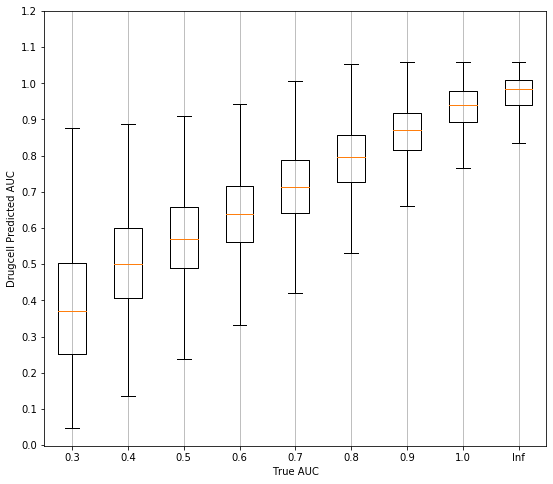

In [7]:
#Drugcell

get_boxplot(test_df, drugcell_pred, "True AUC", "Drugcell Predicted AUC")

In [41]:
sum = 0.0
for i in range(1, 6):
    test_file = '../data/' + str(i) + '_drugcell_test.txt'
    pred_file = '../result/' + str(i) + '_drugcell.predict'
    test = pd.read_csv(test_file, sep='\t', header=None, names=['C', 'D', 'AUC'])['AUC']
    pred = np.loadtxt(pred_file)
    corr = stats.spearmanr(pred, test)[0]
    sum += corr
print("NeST DrugCell Correlation: " + str(sum/5.0))

NeST DrugCell Correlation: 0.7785437223590225


In [33]:
corr = stats.spearmanr(nest_drugcell_pred_cv, test_df['AUC'])[0]
print("Nest DrugCell Correlation: " + str(corr))

Nest DrugCell Correlation: 0.7692387516578694


In [34]:
corr = stats.spearmanr(nest_drugcell_pred_k2, test_df['AUC'])[0]
print("Nest DrugCell Correlation: " + str(corr))

Nest DrugCell Correlation: 0.7622641516037866


In [38]:
corr = stats.spearmanr(nest_drugcell_pred_k4, test_df['AUC'])[0]
print("Nest DrugCell Correlation: " + str(corr))

Nest DrugCell Correlation: 0.7671034815655803


In [42]:
corr = stats.spearmanr(nest_drugcell_pred_k10, test_df['AUC'])[0]
print("Nest DrugCell Correlation: " + str(corr))

Nest DrugCell Correlation: 0.7762678892615631


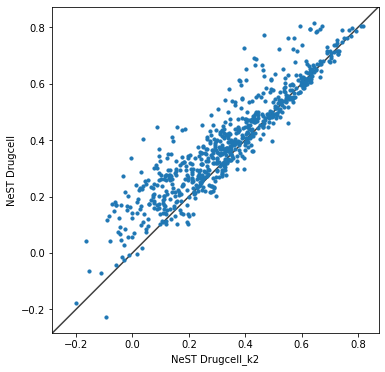

In [32]:
compare_corr(test_df, test_df, nest_drugcell_pred_k2, nest_drugcell_pred_cv, "NeST Drugcell_k2", "NeST Drugcell")

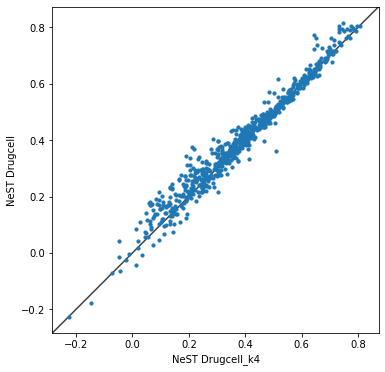

In [39]:
compare_corr(test_df, test_df, nest_drugcell_pred_k4, nest_drugcell_pred_cv, "NeST Drugcell_k4", "NeST Drugcell")

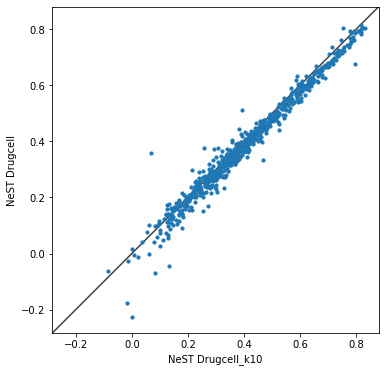

In [43]:
compare_corr(test_df, test_df, nest_drugcell_pred_k10, nest_drugcell_pred_cv, "NeST Drugcell_k10", "NeST Drugcell")

DrugCell Correlation: 0.7795582183341047


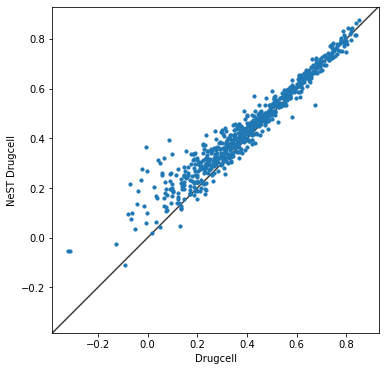

In [14]:
corr = stats.spearmanr(drugcell_pred, test_df['AUC'])[0]
print("DrugCell Correlation: " + str(corr))

compare_corr(test_df, test_df, drugcell_pred, nest_drugcell_pred, "Drugcell", "NeST Drugcell")

In [25]:
ann_pred = np.zeros(len(nest_drugcell_pred))
sum = 0.0
for i in range(1, 7):
    pred_file = '../../ann_nest_drugcell/result/all/' + str(i) + '_drugcell.predict'
    pred = np.loadtxt(pred_file)
    ann_pred = np.add(ann_pred, pred)
    corr = stats.spearmanr(pred, test_df['AUC'])[0]
    sum += corr
for i in range(len(ann_pred)):
    ann_pred[i] /= 6.0

print("Matched NN Corr:" + str(sum/6.0))

Matched NN Corr:0.7837799886799012


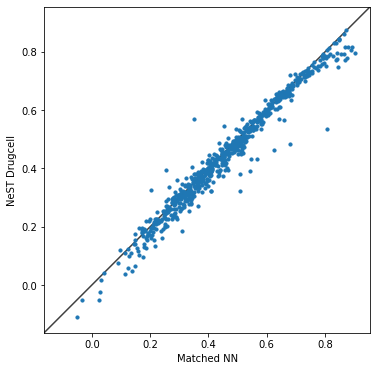

In [26]:
compare_corr(test_df, test_df, ann_pred, nest_drugcell_pred, "Matched NN", "NeST Drugcell")

In [30]:
sum = 0.0
files = [f for f in glob.glob('../../ann_nest_drugcell/result/3600/*.predict')]
for file in files:
    pred = np.loadtxt(file)
    test_file = '../../ann_nest_drugcell/data/' + file.split('_')[3] + '_drugcell_test.txt'
    test = pd.read_csv(test_file, sep='\t', header=None, names=['C', 'D', 'AUC'])['AUC']
    corr = stats.spearmanr(pred, test)[0]
    sum += corr
print("ANN Correlation: " + str(sum/10.0))

ANN Correlation: 0.776075876069449


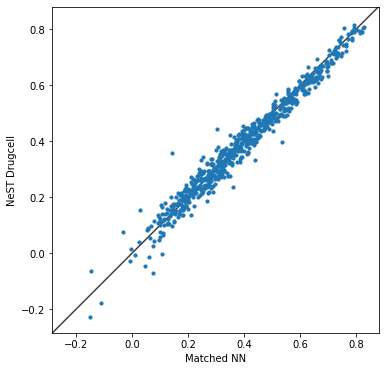

In [31]:
test_r10_df = pd.read_csv('../../ann_nest_drugcell/data/drugcell_r10.txt', sep='\t', header=None, names=['C', 'D', 'AUC'])
ann_pred_r10 = np.loadtxt('../../ann_nest_drugcell/result/drugcell_r10.pred')

compare_corr(test_r10_df, test_df, ann_pred_r10, nest_drugcell_pred_cv, "Matched NN", "NeST Drugcell")

In [32]:
corr = stats.spearmanr(ann_pred_r10, test_r10_df['AUC'])[0]
print("ANN Correlation: " + str(corr))

ANN Correlation: 0.7728005289517168


In [44]:
sum = 0.0
for i in range(1, 5):
    test_file = '../../ann_nest_drugcell/data/' + str(i) + '_drugcell_test.txt'
    pred_file = '../../ann_nest_drugcell/result/' + str(i) + '_drugcell.predict'
    test = pd.read_csv(test_file, sep='\t', header=None, names=['C', 'D', 'AUC'])['AUC']
    pred = np.loadtxt(pred_file)
    corr = stats.spearmanr(pred, test)[0]
    sum += corr
print("ANN NeST DrugCell Correlation: " + str(sum/4.0))

ANN NeST DrugCell Correlation: 0.7720402552462593


ElasticNet Correlation: 0.2739051203944019


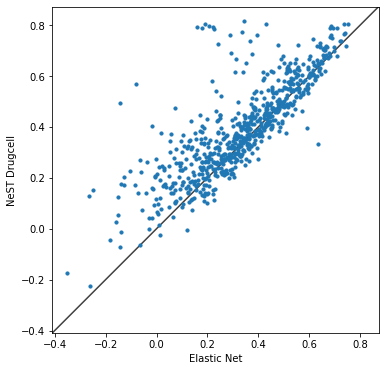

In [16]:
corr = stats.spearmanr(elastic_net_pred, test_df['AUC'])[0]
print("ElasticNet Correlation: " + str(corr))

compare_corr(test_df, test_df, elastic_net_pred, nest_drugcell_pred_cv, "Elastic Net", "NeST Drugcell")